In [1]:
print("Hello world")

Hello world


# Libraries

In [2]:
import pandas as pd
import numpy as np 
import plotly.express as px
import plotly.graph_objects as go
import matplotlib as mpl
import matplotlib.pyplot as plt 
import seaborn as sns
import statsmodels.api as sm 
import os
import warnings
warnings.filterwarnings("ignore")
import re

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from sklearn.manifold import TSNE

In [3]:
plt.rcParams['axes.unicode_minus'] = False
custom_params = {"axes.spines.right": False, "axes.spines.top": False}

sns.set_theme(context = 'talk',  
              style = 'darkgrid',  
              font = 'Malgun Gothic', 
              font_scale = 1.2,         
              rc = custom_params) 

# Read the Data

In [4]:
cur_dir = os.getcwd()

print(cur_dir)
for roots, dirs, files in os.walk(cur_dir):
    if '.git' not in roots:
        print(roots, files)

c:\Users\user\Documents\ML
c:\Users\user\Documents\ML ['.gitignore', 'Company_Rating.ipynb', 'graph.txt', 'Heart_Disease.ipynb', 'Insurance_charge.ipynb', 'Mv_txt.ipynb', 'pre.txt', 'scikit-learn.ipynb', '분석기법별 특징.png']
c:\Users\user\Documents\ML\.vscode ['settings.json']
c:\Users\user\Documents\ML\data ['bestsellers with categories.csv', 'Book_description.npy', 'Companies_Dataset.csv', 'Companies_Dataset.xlsx', 'heart_disease_uci.csv', 'insurance.csv']


In [5]:
data_list = os.listdir(cur_dir + "\data")
Dataset = {}

for data in data_list:
    if '.csv' in data:
        Dataset[data[:-4]] = pd.read_csv(cur_dir + f"\data\{data}")

In [6]:
insu = Dataset['insurance']
df = insu.copy()

In [7]:
df.head(2)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.90,0,yes,southwest,16884.9240
1,18,male,33.77,1,no,southeast,1725.5523


# Data info

## info

In [8]:
print(f"Shape\n\nIndex: {df.shape[0]}\nColumn: {df.shape[1]}")

Shape

Index: 1338
Column: 7


In [9]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [10]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


## duplicate

In [12]:
df[df.duplicated()]

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [13]:
df[df.charges == 1639.5631]

,age,sex,bmi,children,smoker,region,charges
195,19,male,30.59,0,no,northwest,1639.5631
581,19,male,30.59,0,no,northwest,1639.5631


In [14]:
df.drop_duplicates(inplace = True)

## null

In [15]:
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

> clean :)

# EDA

## Numeric

In [16]:
df_num = df.select_dtypes(include = "number")
df_num.head(2)

,age,bmi,children,charges
0,19,27.90,0,16884.9240
1,18,33.77,1,1725.5523


In [17]:
for col in df_num.columns:    
    fig = px.histogram(data_frame = df_num[col],
                       marginal = 'box',
                       nbins = df_num[col].nunique(),
                       color = df['sex'])
    
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

In [18]:
for col in df_num.columns:    
    fig = px.histogram(data_frame = df_num[col],
                       marginal = 'box',
                       nbins = df_num[col].nunique(),
                       color = df['smoker'])
    
    fig.update_layout(title = col, bargap = 0.1)
    fig.show()

In [19]:
px.scatter(x = df['charges'], y = df['age'], symbol = df['smoker'], color = df['sex'], marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')

<Axes: >

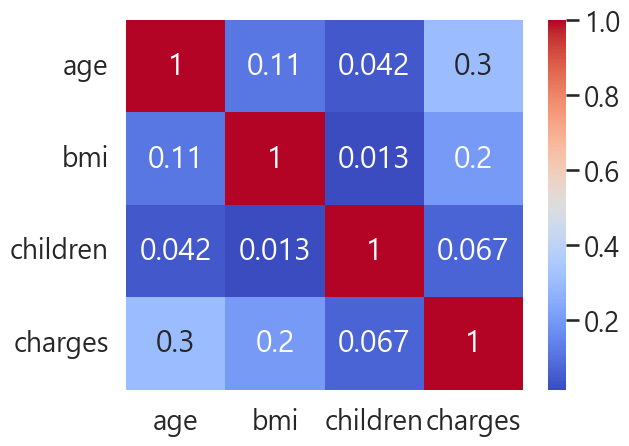

In [20]:
sns.heatmap(df_num.corr(), cmap = "coolwarm", annot = True)

## Categoric

In [21]:
df_cat = df.select_dtypes(include = 'object')
df_cat.head(2)

,sex,smoker,region
0,female,yes,southwest
1,male,no,southeast


In [22]:
for col in df_cat.columns:    
    print(df_cat[col].value_counts())

sex
male      675
female    662
Name: count, dtype: int64
smoker
no     1063
yes     274
Name: count, dtype: int64
region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64


In [23]:
for col in df_cat.columns:
    fig = px.histogram(df_cat[col],
                       marginal = 'rug',
                       color_discrete_sequence = ['#3F72AF'])
    fig.update_layout(title = col)
    fig.show()    

## Columns 'age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'

### sex

In [24]:
df.sex.value_counts()

sex
male      675
female    662
Name: count, dtype: int64

> 원핫인코딩

### bmi

In [25]:
df.bmi.describe()

count    1337.000000
mean       30.663452
std         6.100468
min        15.960000
25%        26.290000
50%        30.400000
75%        34.700000
max        53.130000
Name: bmi, dtype: float64

### children

In [26]:
df.children.value_counts()

children
0    573
1    324
2    240
3    157
4     25
5     18
Name: count, dtype: int64

In [27]:
fig = px.histogram(df.children,
                   marginal = 'box')
fig.update_layout(bargap = 0.1)
fig.show()

### smoker

In [28]:
df.smoker.value_counts()

smoker
no     1063
yes     274
Name: count, dtype: int64

> 원핫인코딩

### region

In [29]:
df.region.value_counts()

region
southeast    364
southwest    325
northwest    324
northeast    324
Name: count, dtype: int64

In [30]:
px.box(data_frame = df,
       x = df.region,
       y = df.charges)

In [31]:
encoded_region = pd.get_dummies(df.region)
encoded_region = encoded_region.astype(int).join(pd.DataFrame(df.charges))
encoded_region.head(5)

,northeast,northwest,southeast,southwest,charges
0,0,0,0,1,16884.92400
1,0,0,1,0,1725.55230
2,0,0,1,0,4449.46200
3,0,1,0,0,21984.47061
4,0,1,0,0,3866.85520


<Axes: >

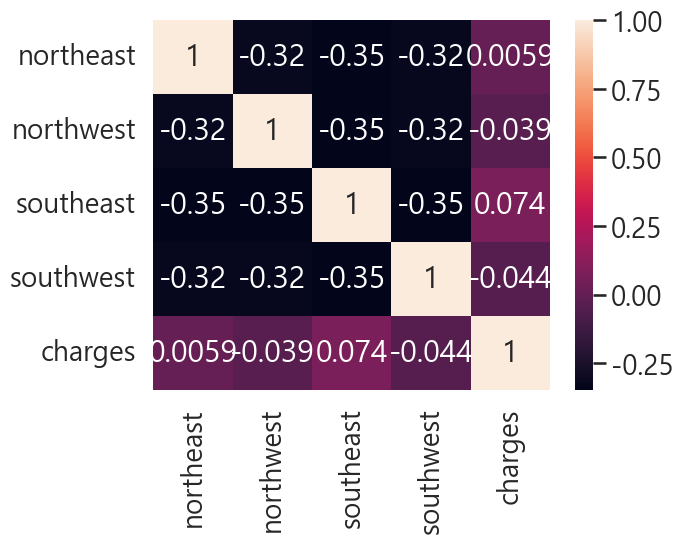

In [32]:
sns.heatmap(encoded_region.corr(), annot = True)

> 컬럼 살려두기...

> 원핫인코딩

### charges (target)

In [33]:
df.charges.describe()

count     1337.000000
mean     13279.121487
std      12110.359656
min       1121.873900
25%       4746.344000
50%       9386.161300
75%      16657.717450
max      63770.428010
Name: charges, dtype: float64

In [34]:
df.charges.median()

9386.1613

In [35]:
fig = px.histogram(df.charges,
                   marginal = 'box',
                   color_discrete_sequence = ['#3F72AF'],
                   nbins = df.charges.nunique())
fig.update_layout(title = "Charges", bargap = 0.1)
fig.show()

In [36]:
df.sort_values(by = 'charges', ascending = False).head(10)

,age,sex,bmi,children,smoker,region,charges
543,54,female,47.410,0,yes,southeast,63770.42801
1300,45,male,30.360,0,yes,southeast,62592.87309
1230,52,male,34.485,3,yes,northwest,60021.39897
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209
1146,60,male,32.800,0,yes,southwest,52590.82939
34,28,male,36.400,1,yes,southwest,51194.55914
1241,64,male,36.960,2,yes,southeast,49577.66240
1062,59,male,41.140,1,yes,southeast,48970.24760
488,44,female,38.060,0,yes,southeast,48885.13561


> outlier 제거 X

> data의 편중이 크기때문에 median으로 나눔

In [37]:
def mktarget(values):
    if values >= df['charges'].median():
        return 1
    return 0

In [38]:
df.charges = df.charges.apply(mktarget)

In [39]:
df

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,1
1,18,male,33.770,1,no,southeast,0
2,28,male,33.000,3,no,southeast,0
3,33,male,22.705,0,no,northwest,1
4,32,male,28.880,0,no,northwest,0
...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,1
1334,18,female,31.920,0,no,northeast,0
1335,18,female,36.850,0,no,southeast,0
1336,21,female,25.800,0,no,southwest,0


# Model

## train test

In [40]:
encoded_df = df.drop(columns = ['sex', 'smoker', 'region']).join(pd.get_dummies(df[['sex', 'smoker', 'region']]))
encoded_df = encoded_df.drop(columns = ['age', 'bmi']).astype('int').join(pd.DataFrame(df[['age', 'bmi']]))

In [41]:
X = encoded_df.drop(columns= ['charges'])
y = encoded_df['charges']

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 777)

## Decision Tree

In [43]:
dt = DecisionTreeClassifier(max_depth = 10, random_state = 777)
dt.fit(X_train, y_train)

# predict the test data
y_pred_dt = dt.predict(X_test)

print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       0.89      0.94      0.91       137
           1       0.93      0.88      0.91       131

    accuracy                           0.91       268
   macro avg       0.91      0.91      0.91       268
weighted avg       0.91      0.91      0.91       268



## Random Forest

In [44]:
rf = RandomForestClassifier(n_estimators=1000, random_state = 777)
rf.fit(X_train, y_train)

# predict the test data
y_pred_rf = rf.predict(X_test)

print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       137
           1       0.97      0.89      0.93       131

    accuracy                           0.93       268
   macro avg       0.94      0.93      0.93       268
weighted avg       0.94      0.93      0.93       268



## SVM

In [45]:
svm = SVC(random_state=777)
svm.fit(X_train, y_train)

y_pred_svm = svm.predict(X_test)

print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.71      0.90      0.79       137
           1       0.85      0.61      0.71       131

    accuracy                           0.76       268
   macro avg       0.78      0.75      0.75       268
weighted avg       0.78      0.76      0.75       268



## XGboost

In [46]:
xgb = XGBClassifier(n_estimators = 100, random_state = 777)
xgb.fit(X_train, y_train)

y_pred_xg = xgb.predict(X_test)

print(classification_report(y_test, y_pred_xg))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95       137
           1       0.98      0.91      0.94       131

    accuracy                           0.94       268
   macro avg       0.95      0.94      0.94       268
weighted avg       0.95      0.94      0.94       268



# Model 평가

In [47]:
tmodel = TSNE(n_components=2)
x_embed = tmodel.fit_transform(X_test)

## Decision Tree

In [53]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_dt, symbol=y_pred_dt, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       137
           1       0.97      0.89      0.93       131

    accuracy                           0.93       268
   macro avg       0.94      0.93      0.93       268
weighted avg       0.94      0.93      0.93       268



## Random Forest

In [52]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_rf, symbol=y_pred_rf, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       137
           1       0.97      0.89      0.93       131

    accuracy                           0.93       268
   macro avg       0.94      0.93      0.93       268
weighted avg       0.94      0.93      0.93       268



## SVM

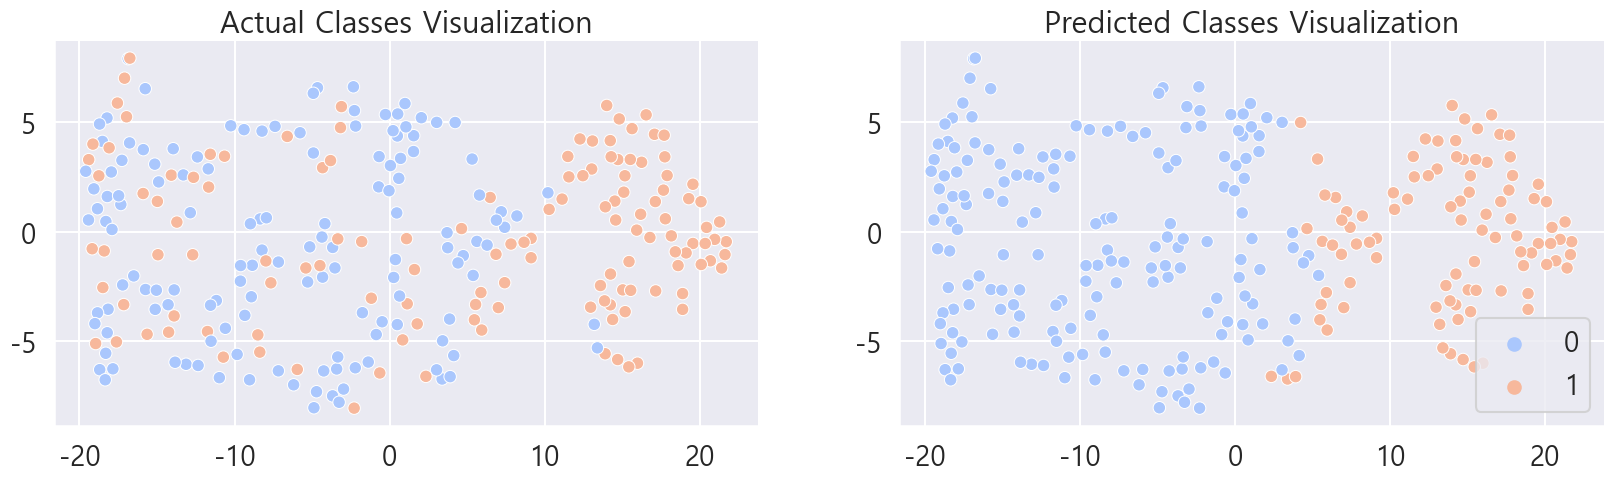

In [50]:
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 2)
sns.scatterplot(x=x_embed[:, 0], y=x_embed[:, 1], hue=y_pred_svm, palette='coolwarm', legend = True)
plt.title('Predicted Classes Visualization')
plt.subplot(1, 2, 1)
sns.scatterplot(x=x_embed[:, 0], y=x_embed[:, 1], hue=y_test, palette='coolwarm', legend = False)
plt.title('Actual Classes Visualization')
plt.show()

## XGboost

In [54]:
print(classification_report(y_test, y_pred_rf))
fig1 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_test, symbol=y_test, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig1.update_layout(title = 'Actual', coloraxis_showscale=False)
fig1.show()
fig2 = px.scatter(x_embed[:,0],x_embed[:,1],color=y_pred_xg, symbol=y_pred_xg, marginal_x = 'histogram', marginal_y = 'rug', trendline = 'ols')
fig2.update_layout(title = 'Predict', coloraxis_showscale=False)
fig2.show()

              precision    recall  f1-score   support

           0       0.90      0.97      0.94       137
           1       0.97      0.89      0.93       131

    accuracy                           0.93       268
   macro avg       0.94      0.93      0.93       268
weighted avg       0.94      0.93      0.93       268

